<a href="https://colab.research.google.com/github/bioinfoUQAM/Identification-Tracking-Cows/blob/main/models/notebooks/demoRunned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics torch torchvision opencv-python pillow numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00


In [3]:
import os
import urllib.request
import torch
import cv2
import numpy as np
from PIL import Image
from ultralytics import YOLO
from torchvision import models, transforms
from IPython.display import display


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
NUM_CLASSES = 29
TOP_K = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [5]:
os.makedirs("models", exist_ok=True)

YOLO_URL = "https://github.com/bioinfoUQAM/Identification-Tracking-Cows/releases/download/v1.0-models/best_yolov8_detection.pt"
ID_URL = "https://github.com/bioinfoUQAM/Identification-Tracking-Cows/releases/download/v1.0-models/best_model_efficientnet_b0.ckpt"

yolo_path = "models/best_yolov8_detection.pt"
id_path = "models/best_model_efficientnet_b0.ckpt"

if not os.path.exists(yolo_path):
    print("Downloading YOLOv8 detection model...")
    urllib.request.urlretrieve(YOLO_URL, yolo_path)

if not os.path.exists(id_path):
    print("Downloading EfficientNet identification model...")
    urllib.request.urlretrieve(ID_URL, id_path)

print("Models ready.")


Models ready.


In [6]:
# Load detection model
yolo = YOLO(yolo_path)

# Load identification model
model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

ckpt = torch.load(id_path, map_location=device)
state_dict = ckpt["state_dict"] if "state_dict" in ckpt else ckpt
state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict, strict=False)
model.eval().to(device)

print("Models loaded successfully.")


Models loaded successfully.


In [7]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [8]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]


Saving Captura de Tela 2026-02-16 às 7.13.23 PM.png to Captura de Tela 2026-02-16 às 7.13.23 PM.png


In [9]:
img_pil = Image.open(image_path).convert("RGB")
results = yolo(image_path)

boxes = []
for r in results:
    for box in r.boxes:
        if r.names[int(box.cls)] == "cow":
            boxes.append(box.xyxy[0].cpu().numpy())

if len(boxes) == 0:
    raise RuntimeError("No cow detected in the image.")



image 1/1 /content/Captura de Tela 2026-02-16 às 7.13.23 PM.png: 640x608 6 cows, 2198.0ms
Speed: 12.7ms preprocess, 2198.0ms inference, 37.3ms postprocess per image at shape (1, 3, 640, 608)


Top-3 identity predictions:

1. Cow ID 27 — confidence 0.746
2. Cow ID 06 — confidence 0.088
3. Cow ID 13 — confidence 0.036


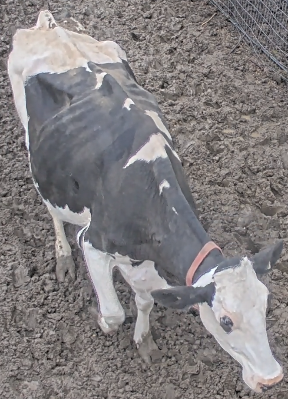

In [10]:
x1, y1, x2, y2 = map(int, boxes[0])
crop = img_pil.crop((x1, y1, x2, y2))

input_tensor = preprocess(crop).unsqueeze(0).to(device)

with torch.no_grad():
    probs = torch.softmax(model(input_tensor), dim=1)[0]

top_probs, top_ids = torch.topk(probs, TOP_K)

print("Top-3 identity predictions:\n")
for rank, (pid, prob) in enumerate(zip(top_ids, top_probs), 1):
    print(f"{rank}. Cow ID {pid.item():02d} — confidence {prob.item():.3f}")

display(crop)
